In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Daten normalisieren
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]
ZR_12_TR, ZR_12_TE= ZR_12[0:50], ZR_12[50:len(ZR_12)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]
ZR_N12=ZR_N[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]
ZR_N12_TR, ZR_N12_TE= ZR_N12[0:50], ZR_N12[50:len(ZR_N12)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back=1, look_forward=1):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: 1
look_back=12
look_forward=1

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)

# Inputgröße 12%
# Trainingsdaten
ZR_12_TR_I=timeseries_to_supervised_R(ZR_12_TR, look_back, look_forward)

# Testdaten 
ZR_12_TE_I=timeseries_to_supervised_R(ZR_12_TE, look_back, look_forward)

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)


# Inputgröße 12%
# Trainingsdaten
ZR_N12_TR_I=timeseries_to_supervised_R(ZR_N12_TR, look_back, look_forward)

# Testdaten 
ZR_N12_TE_I=timeseries_to_supervised_R(ZR_N12_TE, look_back, look_forward)

In [9]:
# Funktion: X,y trennen, Form von X anpassen, Modell zusammenbauen, Modell anpassen
def fit_lstm(train, batch_size, nb_epochs, blocks):
    X, y = train.iloc[:, 0:-1], train.iloc[:, -1]
    X=array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1]) 
    model = Sequential()
    model.add(LSTM(blocks, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(LSTM(blocks))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epochs):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [10]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [11]:
# Modell anpassen: 100% der originalen Datensatzstärke
lstm_model_100 = fit_lstm(ZR_N100_TR_I, 1, 30, 4)

In [12]:
# Funktion zur Vorhersage definieren
def forecast_lstm(model, batch_size, X):
    X=array(X)
    X = X.reshape(1, 1, len(X)) # 1,1 hat nichts mit look_forward oder look_backward zu tun!
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [13]:
# Validierung des Modells anhand der Testdaten
predictions_100 = list()
for i in range(len(ZR_N100_TE_I)):
    # Vorhersage erzeugen 
    X, y = ZR_N100_TE_I.iloc[i, 0:-1], ZR_N100_TE_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_100, 1, X)
    predictions_100.append(yhat)
    expected = ZR_N100[len(ZR_N100_TR_I) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.262996, Expected=0.223510
Month=2, Predicted=0.294989, Expected=0.280323
Month=3, Predicted=0.283545, Expected=0.269972
Month=4, Predicted=0.261754, Expected=0.253233
Month=5, Predicted=0.241877, Expected=0.232648
Month=6, Predicted=0.222144, Expected=0.170517
Month=7, Predicted=0.212276, Expected=0.170399
Month=8, Predicted=0.205907, Expected=0.208309
Month=9, Predicted=0.207550, Expected=0.183214
Month=10, Predicted=0.201741, Expected=0.224774
Month=11, Predicted=0.211989, Expected=0.178704
Month=12, Predicted=0.223442, Expected=0.210825
Month=13, Predicted=0.229751, Expected=0.232896
Month=14, Predicted=0.232568, Expected=0.311024
Month=15, Predicted=0.249828, Expected=0.304401
Month=16, Predicted=0.237968, Expected=0.303071
Month=17, Predicted=0.220538, Expected=0.260064
Month=18, Predicted=0.207488, Expected=0.215792
Month=19, Predicted=0.203171, Expected=0.247627
Month=20, Predicted=0.193518, Expected=0.292355
Month=21, Predicted=0.199606, Expected=0.218530
M

Month=208, Predicted=0.205109, Expected=0.152461
Month=209, Predicted=0.191419, Expected=0.129530
Month=210, Predicted=0.174268, Expected=0.073917
Month=211, Predicted=0.165355, Expected=0.069641
Month=212, Predicted=0.154969, Expected=0.104279
Month=213, Predicted=0.154428, Expected=0.024326
Month=214, Predicted=0.145211, Expected=0.082156
Month=215, Predicted=0.156429, Expected=0.074529
Month=216, Predicted=0.172048, Expected=0.115347
Month=217, Predicted=0.200833, Expected=0.119270
Month=218, Predicted=0.214738, Expected=0.212338
Month=219, Predicted=0.234124, Expected=0.189289
Month=220, Predicted=0.225089, Expected=0.193005
Month=221, Predicted=0.211353, Expected=0.133037
Month=222, Predicted=0.191755, Expected=0.066030
Month=223, Predicted=0.178319, Expected=0.081673
Month=224, Predicted=0.166515, Expected=0.125111
Month=225, Predicted=0.174734, Expected=0.070710
Month=226, Predicted=0.170310, Expected=0.109506
Month=227, Predicted=0.180363, Expected=0.106104
Month=228, Predicted

In [14]:
# Skalierung zurücksetzten
predictions_100=np.reshape(predictions_100,(len(predictions_100),1))
predictions_100=scaler.inverse_transform(predictions_100)

Test MSE: 15924204.127


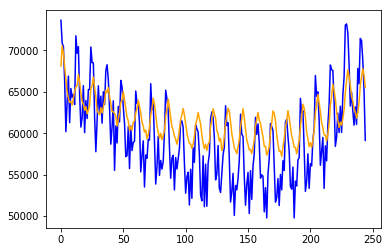

In [15]:
# Modellperformance bewerten
mse = mean_squared_error(ZR_100[-len(predictions_100):], predictions_100)
print('Test MSE: %.3f' % mse)
# Vorhersage und Testdaten abtragen
plt.plot(ZR_100[-len(predictions_100):], color='blue')
plt.plot(predictions_100, color='orange')
plt.show()

In [16]:
predictions_train_100 = list()
for i in range(len(ZR_N100_TR_I)):
    # Vorhersage erzeugen
    X, y = ZR_N100_TR_I.iloc[i, 0:-1], ZR_N100_TR_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_100, 1, X)
    predictions_train_100.append(yhat)
    expected = ZR_N100[ i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.289564, Expected=0.057608
Month=2, Predicted=0.318242, Expected=0.288836
Month=3, Predicted=0.317157, Expected=0.342833
Month=4, Predicted=0.332791, Expected=0.449679
Month=5, Predicted=0.335867, Expected=0.429707
Month=6, Predicted=0.343058, Expected=0.470811
Month=7, Predicted=0.334100, Expected=0.456041
Month=8, Predicted=0.343214, Expected=0.501017
Month=9, Predicted=0.335398, Expected=0.486846
Month=10, Predicted=0.330678, Expected=0.397051
Month=11, Predicted=0.318134, Expected=0.450149
Month=12, Predicted=0.323011, Expected=0.551885
Month=13, Predicted=0.324334, Expected=0.440463
Month=14, Predicted=0.350460, Expected=0.529397
Month=15, Predicted=0.338586, Expected=0.457762
Month=16, Predicted=0.350892, Expected=0.505866
Month=17, Predicted=0.348854, Expected=0.467565
Month=18, Predicted=0.352868, Expected=0.494955
Month=19, Predicted=0.342743, Expected=0.458883
Month=20, Predicted=0.352263, Expected=0.520063
Month=21, Predicted=0.343954, Expected=0.433801
M

Month=180, Predicted=0.375496, Expected=0.830409
Month=181, Predicted=0.389741, Expected=0.759973
Month=182, Predicted=0.404145, Expected=0.935065
Month=183, Predicted=0.401819, Expected=0.840382
Month=184, Predicted=0.409691, Expected=0.867654
Month=185, Predicted=0.402413, Expected=0.768290
Month=186, Predicted=0.400627, Expected=0.784299
Month=187, Predicted=0.388569, Expected=0.780857
Month=188, Predicted=0.390391, Expected=0.788914
Month=189, Predicted=0.381850, Expected=0.767599
Month=190, Predicted=0.378764, Expected=0.725244
Month=191, Predicted=0.374290, Expected=0.778276
Month=192, Predicted=0.374521, Expected=0.832312
Month=193, Predicted=0.390099, Expected=0.752425
Month=194, Predicted=0.408358, Expected=0.917375
Month=195, Predicted=0.407762, Expected=0.832064
Month=196, Predicted=0.423397, Expected=0.879960
Month=197, Predicted=0.415341, Expected=0.789122
Month=198, Predicted=0.411556, Expected=0.803410
Month=199, Predicted=0.394901, Expected=0.805627
Month=200, Predicted

Month=364, Predicted=0.233594, Expected=0.272071
Month=365, Predicted=0.239412, Expected=0.247080
Month=366, Predicted=0.253348, Expected=0.276712
Month=367, Predicted=0.242997, Expected=0.259921
Month=368, Predicted=0.242671, Expected=0.273635
Month=369, Predicted=0.222653, Expected=0.205885
Month=370, Predicted=0.217181, Expected=0.173267
Month=371, Predicted=0.201484, Expected=0.180985
Month=372, Predicted=0.200788, Expected=0.232283
Month=373, Predicted=0.201166, Expected=0.182015
Month=374, Predicted=0.222531, Expected=0.309107
Month=375, Predicted=0.221440, Expected=0.251017
Month=376, Predicted=0.246317, Expected=0.317190
Month=377, Predicted=0.249567, Expected=0.279658
Month=378, Predicted=0.251585, Expected=0.275108
Month=379, Predicted=0.241775, Expected=0.262815
Month=380, Predicted=0.242101, Expected=0.271771
Month=381, Predicted=0.223135, Expected=0.230015
Month=382, Predicted=0.214541, Expected=0.191193
Month=383, Predicted=0.200134, Expected=0.202156
Month=384, Predicted

Month=574, Predicted=0.203464, Expected=0.159736
Month=575, Predicted=0.190439, Expected=0.179017
Month=576, Predicted=0.190493, Expected=0.216900
Month=577, Predicted=0.187157, Expected=0.156203
Month=578, Predicted=0.192879, Expected=0.230119
Month=579, Predicted=0.187158, Expected=0.207892
Month=580, Predicted=0.193680, Expected=0.231958
Month=581, Predicted=0.192691, Expected=0.226847
Month=582, Predicted=0.207593, Expected=0.259738
Month=583, Predicted=0.221652, Expected=0.248357
Month=584, Predicted=0.233050, Expected=0.232075
Month=585, Predicted=0.219953, Expected=0.184896
Month=586, Predicted=0.216954, Expected=0.153726
Month=587, Predicted=0.207797, Expected=0.187699
Month=588, Predicted=0.196658, Expected=0.206915
Month=589, Predicted=0.185012, Expected=0.145461
Month=590, Predicted=0.192847, Expected=0.213081
Month=591, Predicted=0.183871, Expected=0.133624
Month=592, Predicted=0.191282, Expected=0.179603


In [17]:
# Skalierung zurücksetzten
predictions_train_100=np.reshape(predictions_train_100,(len(predictions_train_100),1))
predictions_train_100=scaler.inverse_transform(predictions_train_100)

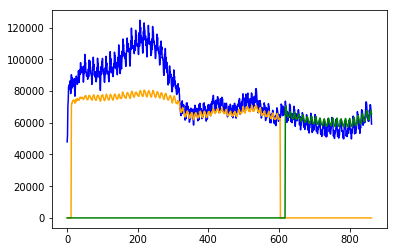

In [18]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
predictions_train_100=predictions_train_100.reshape(len(predictions_train_100))
trainPredictPlot[(look_back+look_forward-1):len(predictions_train_100)+(look_back+look_forward-1)] = predictions_train_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
predictions_100=predictions_100.reshape(len(predictions_100))
testPredictPlot[-len(predictions_100):] = predictions_100

# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [19]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [20]:
# Modell anpassen: 46% der originalen Datensatzstärke
lstm_model_46 = fit_lstm(ZR_N46_TR_I, 1, 30, 4)

In [21]:
# Validierung des Modells anhand der Testdaten
predictions_46 = list()
for i in range(len(ZR_N46_TE_I)):
    # Vorhersage erzeugen 
    X, y = ZR_N46_TE_I.iloc[i, 0:-1], ZR_N46_TE_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_46, 1, X)
    predictions_46.append(yhat)
    expected = ZR_N46[len(ZR_N46_TR_I) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.091628, Expected=0.159162
Month=2, Predicted=0.125609, Expected=0.225074
Month=3, Predicted=0.136033, Expected=0.211464
Month=4, Predicted=0.132424, Expected=0.192770
Month=5, Predicted=0.126082, Expected=0.136283
Month=6, Predicted=0.118498, Expected=0.086679
Month=7, Predicted=0.111294, Expected=0.118332
Month=8, Predicted=0.108300, Expected=0.122777
Month=9, Predicted=0.107570, Expected=0.068376
Month=10, Predicted=0.104008, Expected=0.119297
Month=11, Predicted=0.106802, Expected=0.101215
Month=12, Predicted=0.113302, Expected=0.116624
Month=13, Predicted=0.125166, Expected=0.133311
Month=14, Predicted=0.131694, Expected=0.176657
Month=15, Predicted=0.134402, Expected=0.176722
Month=16, Predicted=0.130696, Expected=0.166215
Month=17, Predicted=0.126132, Expected=0.110797
Month=18, Predicted=0.120788, Expected=0.063162
Month=19, Predicted=0.119055, Expected=0.088700
Month=20, Predicted=0.114972, Expected=0.096196
Month=21, Predicted=0.113185, Expected=0.044585
M

In [22]:
# Skalierung zurücksetzten
predictions_46=np.reshape(predictions_46,(len(predictions_46),1))
predictions_46=scaler.inverse_transform(predictions_46)

Test MSE: 14930790.434


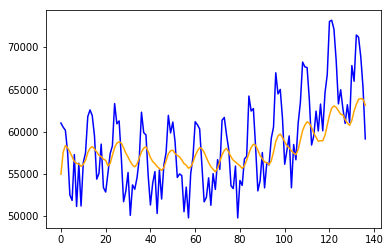

In [23]:
# Modellperformance bewerten
mse = mean_squared_error(ZR_46[-len(predictions_46):], predictions_46)
print('Test MSE: %.3f' % mse)
# Vorhersage und Testdaten abtragen
plt.plot(ZR_46[-len(predictions_46):], color='blue')
plt.plot(predictions_46, color='orange')
plt.show()

In [24]:
predictions_train_46 = list()
for i in range(len(ZR_N46_TR_I)):
    # Vorhersage erzeugen 
    X, y = ZR_N46_TR_I.iloc[i, 0:-1], ZR_N46_TR_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_46, 1, X)
    predictions_train_46.append(yhat)
    expected = ZR_N46[ i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.206524, Expected=0.276451
Month=2, Predicted=0.206245, Expected=0.258943
Month=3, Predicted=0.201433, Expected=0.212051
Month=4, Predicted=0.196179, Expected=0.211151
Month=5, Predicted=0.196376, Expected=0.271315
Month=6, Predicted=0.198644, Expected=0.198128
Month=7, Predicted=0.202311, Expected=0.299982
Month=8, Predicted=0.201216, Expected=0.264158
Month=9, Predicted=0.206716, Expected=0.289592
Month=10, Predicted=0.211716, Expected=0.229481
Month=11, Predicted=0.214987, Expected=0.318363
Month=12, Predicted=0.217076, Expected=0.282995
Month=13, Predicted=0.217608, Expected=0.298717
Month=14, Predicted=0.217397, Expected=0.266283
Month=15, Predicted=0.212959, Expected=0.197176
Month=16, Predicted=0.206467, Expected=0.196433
Month=17, Predicted=0.210204, Expected=0.291573
Month=18, Predicted=0.211831, Expected=0.220811
Month=19, Predicted=0.211485, Expected=0.293151
Month=20, Predicted=0.212605, Expected=0.306383
Month=21, Predicted=0.216102, Expected=0.310098
M

Month=199, Predicted=0.142737, Expected=0.169109
Month=200, Predicted=0.141037, Expected=0.142123
Month=201, Predicted=0.147185, Expected=0.199640
Month=202, Predicted=0.152493, Expected=0.175275
Month=203, Predicted=0.158379, Expected=0.240562
Month=204, Predicted=0.163376, Expected=0.230185
Month=205, Predicted=0.163166, Expected=0.198623
Month=206, Predicted=0.157307, Expected=0.172577
Month=207, Predicted=0.150397, Expected=0.120639
Month=208, Predicted=0.143759, Expected=0.122282
Month=209, Predicted=0.142164, Expected=0.167949
Month=210, Predicted=0.137802, Expected=0.101971
Month=211, Predicted=0.134032, Expected=0.168913
Month=212, Predicted=0.126768, Expected=0.130182
Month=213, Predicted=0.129731, Expected=0.142958
Month=214, Predicted=0.139642, Expected=0.144900
Month=215, Predicted=0.148816, Expected=0.223797
Month=216, Predicted=0.155560, Expected=0.204372
Month=217, Predicted=0.158441, Expected=0.202521
Month=218, Predicted=0.154866, Expected=0.173424
Month=219, Predicted

In [25]:
# Skalierung zurücksetzten
predictions_train_46=np.reshape(predictions_train_46,(len(predictions_train_46),1))
predictions_train_46=scaler.inverse_transform(predictions_train_46)

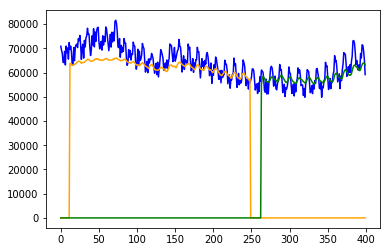

In [26]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
predictions_train_46=predictions_train_46.reshape(len(predictions_train_46))
trainPredictPlot[(look_back+look_forward-1):len(predictions_train_46)+(look_back+look_forward-1)] = predictions_train_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
predictions_46=predictions_46.reshape(len(predictions_46))
testPredictPlot[-len(predictions_46):] = predictions_46

# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [27]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [28]:
# Modell anpassen: 12% der originalen Datensatzstärke
lstm_model_12 = fit_lstm(ZR_N12_TR_I, 1, 30, 4)

In [29]:
# Validierung des Modells anhand der Testdaten
predictions_12 = list()
for i in range(len(ZR_N12_TE_I)):
    # Vorhersage erzeugen
    X, y = ZR_N12_TE_I.iloc[i, 0:-1], ZR_N12_TE_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_12, 1, X)
    predictions_12.append(yhat)
    expected = ZR_N12[len(ZR_N12_TR_I) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.062382, Expected=0.129530
Month=2, Predicted=0.053771, Expected=0.073917
Month=3, Predicted=0.052173, Expected=0.069641
Month=4, Predicted=0.045394, Expected=0.104279
Month=5, Predicted=0.045505, Expected=0.024326
Month=6, Predicted=0.054866, Expected=0.082156
Month=7, Predicted=0.070097, Expected=0.074529
Month=8, Predicted=0.091208, Expected=0.115347
Month=9, Predicted=0.120290, Expected=0.119270
Month=10, Predicted=0.141035, Expected=0.212338
Month=11, Predicted=0.150148, Expected=0.189289
Month=12, Predicted=0.150508, Expected=0.193005
Month=13, Predicted=0.131379, Expected=0.133037
Month=14, Predicted=0.106753, Expected=0.066030
Month=15, Predicted=0.089639, Expected=0.081673
Month=16, Predicted=0.069718, Expected=0.125111
Month=17, Predicted=0.065213, Expected=0.070710
Month=18, Predicted=0.069157, Expected=0.109506
Month=19, Predicted=0.081750, Expected=0.106104
Month=20, Predicted=0.101722, Expected=0.147090
Month=21, Predicted=0.125644, Expected=0.164598
M

In [30]:
# Skalierung zurücksetzten
predictions_12=np.reshape(predictions_12,(len(predictions_12),1))
predictions_12=scaler.inverse_transform(predictions_12)

Test MSE: 81608918.135


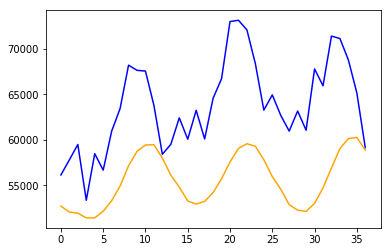

In [32]:
# Modellperformance bewerten
mse = mean_squared_error(ZR_12[-len(predictions_12):], predictions_12)
print('Test MSE: %.3f' % mse)
# Vorhersage und Testdaten abtragen
plt.plot(ZR_12[-len(predictions_12):], color='blue')
plt.plot(predictions_12, color='orange')
plt.show()

In [33]:
predictions_train_12 = list()
for i in range(len(ZR_N12_TR_I)):
    # Vorhersage erzeugen 
    X, y = ZR_N12_TR_I.iloc[i, 0:-1], ZR_N12_TR_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_12, 1, X)
    predictions_train_12.append(yhat)
    expected = ZR_N12[i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=0.152359, Expected=0.152422
Month=2, Predicted=0.152874, Expected=0.089169
Month=3, Predicted=0.137870, Expected=0.044311
Month=4, Predicted=0.119925, Expected=0.077554
Month=5, Predicted=0.106651, Expected=0.095857
Month=6, Predicted=0.088342, Expected=0.031209
Month=7, Predicted=0.081783, Expected=0.098634
Month=8, Predicted=0.081154, Expected=0.053449
Month=9, Predicted=0.087010, Expected=0.106038
Month=10, Predicted=0.101593, Expected=0.125293
Month=11, Predicted=0.122417, Expected=0.182484
Month=12, Predicted=0.139713, Expected=0.155460
Month=13, Predicted=0.149994, Expected=0.172146
Month=14, Predicted=0.151911, Expected=0.142045
Month=15, Predicted=0.136624, Expected=0.086771
Month=16, Predicted=0.117097, Expected=0.092155
Month=17, Predicted=0.099789, Expected=0.089717
Month=18, Predicted=0.083007, Expected=0.033895
Month=19, Predicted=0.077500, Expected=0.071870
Month=20, Predicted=0.079863, Expected=0.024391
Month=21, Predicted=0.091502, Expected=0.093067
M

In [34]:
# Skalierung zurücksetzten
predictions_train_12=np.reshape(predictions_train_12,(len(predictions_train_12),1))
predictions_train_12=scaler.inverse_transform(predictions_train_12)

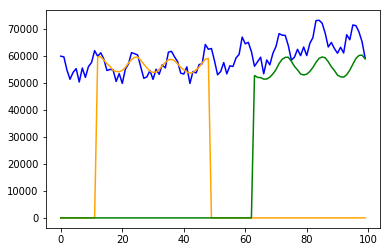

In [35]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_12)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_12))
trainPredictPlot[:]=[0]*len(ZR_12)
predictions_train_12=predictions_train_12.reshape(len(predictions_train_12))
trainPredictPlot[(look_back+look_forward-1):len(predictions_train_12)+(look_back+look_forward-1)] = predictions_train_12

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_12)
testPredictPlot=testPredictPlot.reshape(len(ZR_12))
testPredictPlot[:]=[0]*len(ZR_12)
predictions_12=predictions_12.reshape(len(predictions_12))
testPredictPlot[-len(predictions_12):] = predictions_12

# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_12, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()